# 1. Extracción de imágenes de Google

In [1]:
import hashlib
from PIL import Image
import io, os
import requests
import time
import selenium
from selenium import webdriver

In [2]:
wd = webdriver.Chrome('chromedriver.exe')

In [3]:
def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=2):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        print(image_count,max_links_to_fetch)
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        
        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

In [4]:
def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")

In [5]:
def search_and_download(search_term:str,driver_path:str,target_path='./images',number_images=5):
    target_folder = os.path.join(target_path,'_'.join(search_term.lower().split(' ')))

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    with webdriver.Chrome(executable_path=driver_path) as wd:
        res = fetch_image_urls(search_term, number_images, wd=wd, sleep_between_interactions=0.1)
        
    for elem in res:
        persist_image(target_folder,elem)

In [6]:
search_term = 'patinete'
search_and_download(search_term,'chromedriver.exe',number_images=100)

0 100
Found: 100 search results. Extracting links from 0:100
88 100
Found: 212 search results. Extracting links from 100:212
88 100
Found: 100 search results. Extracting links from 212:100
88 100
Found: 100 search results. Extracting links from 100:100
88 100
Found: 100 search results. Extracting links from 100:100
88 100
Found: 100 search results. Extracting links from 100:100
88 100
Found: 100 search results. Extracting links from 100:100
88 100
Found: 100 search results. Extracting links from 100:100
88 100
Found: 100 search results. Extracting links from 100:100
88 100
Found: 100 search results. Extracting links from 100:100
88 100
Found: 200 search results. Extracting links from 100:200
Found: 100 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSF0oV3TskRgWTBEErci0ugG1TJ0uf6TTl2Ng&usqp=CAU - as ./images\patinete\61790bbc82.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQNi8XGPaImF9st0NJZelBBQEFuh21PoE43GQ&usqp=CAU

C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


SUCCESS - saved https://assets.mmsrg.com/isr/166325/c1/-/ASSET_MMS_88702570/fee_325_225_png - as ./images\patinete\50e7e8bbfe.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSNr9nVGSuaCkebo6gVF2FEdCJ7kT5KcvGcag&usqp=CAU - as ./images\patinete\fe04348e3e.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRvZZMu1NlOgR2HjqHbGdyK1fF5t0GB9El2fA&usqp=CAU - as ./images\patinete\d851b10ec5.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ-wC8C4cptZKp5cR5Xg-p6qoFddO9QXC2EJA&usqp=CAU - as ./images\patinete\c074d598a3.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSBApQyt2tRgjhLBRfZVYe2gJfVQJiwahsgqg&usqp=CAU - as ./images\patinete\96328e11b3.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT22Xstiw7Y361j5z2seLu9TTAzfubVspwqow&usqp=CAU - as ./images\patinete\cc242ea0d9.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQMezpnbrer_4i47TEHN1MtOFhwy1k6

SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT9KrWth1LnSnl8pLy_lZgHZZ_hNNyQGWdhRg&usqp=CAU - as ./images\patinete\9655809ef8.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQbLZHl4BjcYr_hdGs1cTNAVFeKeKOdj1HT0w&usqp=CAU - as ./images\patinete\0a6eacb44d.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQlftheRBIc1wTPWbAfqJoLdg6OnvWmzluslw&usqp=CAU - as ./images\patinete\df7403d165.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS8tcRcSMYD_b56NmDlAEDyA3RuGFI-TZxX6w&usqp=CAU - as ./images\patinete\3c42144376.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTtyrtpDNiWSe-lzI46gzcCQvU6pwxtkzTqwg&usqp=CAU - as ./images\patinete\c73d0f4096.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRw9ukfSFjBTyTzkIsrzSKcZB7LeY1SQwk1jA&usqp=CAU - as ./images\patinete\abd479ed13.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS74D3u

In [7]:
search_term = 'bicicleta'
search_and_download(search_term,'chromedriver.exe',number_images=100)

0 100
Found: 100 search results. Extracting links from 0:100
88 100
Found: 212 search results. Extracting links from 100:212
Found: 100 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSJ8Hz_2aJnPnD3jX0Q4Nw3G38QB5_wkSzVzw&usqp=CAU - as ./images\bicicleta\6a14f57379.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTc9K4_oLEe0VydhvlRGMa0XcLKiB8CeMu2Ww&usqp=CAU - as ./images\bicicleta\96dafa8eab.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTQluXt8KJUNMbYjjEK6Z9EpStalKcRdbUX3A&usqp=CAU - as ./images\bicicleta\b6871a0697.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRcWqRIniIi_MNnTJ5zXkqfnVemT1CTFdhkrw&usqp=CAU - as ./images\bicicleta\131fc1c7ea.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR3LytSWVbKgG1D-mAoUjAGppr8F7X3VrFjcw&usqp=CAU - as ./images\bicicleta\6d116a2b01.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9Gc

SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSiHVp6-c9wmPE_SNs9tnsw-ASNjbAmptKo4g&usqp=CAU - as ./images\bicicleta\f5d5be0697.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSTtuK5JF_GSDxL3vtYmR8jPC7sZZ18rkyBHQ&usqp=CAU - as ./images\bicicleta\d7b29db780.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcROWWjttwip9yxZW1Hi4tLCvtYTmo6kyD7XZg&usqp=CAU - as ./images\bicicleta\a683eff019.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTkWo7hOer1l-jb5ExLFfxrfIVcOtAuIyYF6g&usqp=CAU - as ./images\bicicleta\4d1b6ee2b5.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS39GMVkSLxvZvgnUyZ3vNzo0d-FHOnl0tbNA&usqp=CAU - as ./images\bicicleta\684aac3083.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRGXznbjd_kN4yPoaX4IsC53XF7HUlkHjPlrA&usqp=CAU - as ./images\bicicleta\0117a230f6.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9Gc

# 2. Data Augmentation

In [8]:
from keras.preprocessing.image import ImageDataGenerator
import os
from os.path import isfile, join
import pandas as pd
import numpy as np
from skimage.io import imread

In [9]:
# 1. Iniciar el data generator
datagen = ImageDataGenerator(rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.15,
                            zoom_range=0.1,
                            channel_shift_range=10,
                            horizontal_flip=True)

In [10]:
# 2. Aplicar las transfromaciones en una imagen
patinetes = ['images/patinete/'+ f for f in os.listdir('images/patinete') if isfile(join('images/patinete', f))]
image_path = patinetes[0]
image = np.expand_dims(imread(image_path),axis=0)

In [11]:
# 3. Selecciona dónde quieres guardar las imágenes transformadas
save_here = 'images/patinete/aug'
try:
    os.stat(save_here)
except:
    os.mkdir(save_here)

In [12]:
# Fit de la imagen original
datagen.fit(image)

In [13]:
for x, val in zip(datagen.flow(image,           #image we chose
        save_to_dir=save_here,     #this is where we figure out where to save
         save_prefix='aug',        # it will save the images as 'aug_0912' some number for every new augmented image
        save_format='png'),range(10)):     # here we define a range because we want 10 augmented images 
    pass

In [14]:
# Para todos las imágenes de la clase 1
for image_path in patinetes:
    image = np.expand_dims(imread(image_path),axis=0)
    datagen.fit(image)
    for x, val in zip(datagen.flow(image,                    #image we chose
        save_to_dir=save_here,     #this is where we figure out where to save
         save_prefix='aug',        # it will save the images as 'aug_0912' some number for every new augmented image
        save_format='png'),range(3)):     # here we define a range because we want 10 augmented images 
        pass

In [15]:
# Realiza la misma operación para las bicicletas
bicicletas = ['images/bicicleta/'+ f for f in os.listdir('images/bicicleta') if isfile(join('images/bicicleta', f))]
save_here = 'images/bicicleta/aug'
try:
    os.stat(save_here)
except:
    os.mkdir(save_here)  
    
for image_path in bicicletas:
    image = np.expand_dims(imread(image_path),axis=0)
    datagen.fit(image)
    for x, val in zip(datagen.flow(image,                    #image we chose
        save_to_dir=save_here,     #this is where we figure out where to save
         save_prefix='aug',        # it will save the images as 'aug_0912' some number for every new augmented image
        save_format='png'),range(3)):     # here we define a range because we want 10 augmented images 
        pass

# 3. Preparar los datos

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import cv2

In [17]:
# Read data
X = []
Y = []
for file in os.listdir('images/patinete/aug'):
    image = imread('images/patinete/aug/'+file)
    smallimage = cv2.resize(image,(64,64))
    X.append(smallimage)
    Y.append(0)
    
for file in os.listdir('images/bicicleta/aug'):
    image = imread('images/bicicleta/aug/'+file)
    smallimage = cv2.resize(image,(64,64))
    X.append(smallimage)
    Y.append(1)

In [18]:
X,Y = np.array(X), np.array(Y)

In [19]:
X = X/255.0
print('Min:',np.min(X))
print('Max:',np.max(X))

Min: 0.0
Max: 1.0


In [20]:
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=42)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, 
                                                    random_state=40)
print(X_train.shape); print(X_test.shape)

(636, 64, 64, 3)
(159, 64, 64, 3)


#  Transfer Learning

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [23]:
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape=(64,64,3),
                  include_top = False,
                   weights = 'imagenet'
                  )

In [24]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [25]:
for layer in base_model.layers:
    layer.trainable = False

In [26]:
    
##### FULLY CONNECTED LAYER #####
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output) # Añado una flatten a la salida del base_model, al cual le quité el top CAPA(CAPA ANTERIOR)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x) # Añado una densa a x (flatten)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['acc'])

In [27]:
vgghist = model.fit(X_train,y_train,
                    epochs = 10)

Epoch 1/10
20/20 [==============================] - 7s 279ms/step - loss: 0.3112 - acc: 0.8726
Epoch 2/10
20/20 [==============================] - 6s 304ms/step - loss: 0.0780 - acc: 0.9717
Epoch 3/10
20/20 [==============================] - 7s 339ms/step - loss: 0.0396 - acc: 0.9843
Epoch 4/10
20/20 [==============================] - 7s 364ms/step - loss: 0.0204 - acc: 0.9984
Epoch 5/10
20/20 [==============================] - 8s 403ms/step - loss: 0.0119 - acc: 1.0000
Epoch 6/10
20/20 [==============================] - 8s 415ms/step - loss: 0.0106 - acc: 0.9984
Epoch 7/10
20/20 [==============================] - 7s 370ms/step - loss: 0.0055 - acc: 1.0000
Epoch 8/10
20/20 [==============================] - 7s 363ms/step - loss: 0.0066 - acc: 0.9969
Epoch 9/10
20/20 [==============================] - 7s 370ms/step - loss: 0.0069 - acc: 0.9984
Epoch 10/10
20/20 [==============================] - 7s 351ms/step - loss: 0.0102 - acc: 0.9984


In [28]:
results = model.evaluate(X_test, y_test)
print("test loss, test accuracy", results)

5/5 [==============================] - 2s 377ms/step - loss: 0.0183 - acc: 0.9937
test loss, test accuracy [0.018335385248064995, 0.9937106966972351]


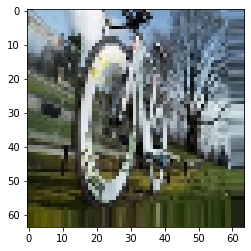

In [31]:
plt.imshow(X_test[4]) 

In [32]:
model.predict(np.expand_dims(X_test[4], axis=0))

array([[0.9999996]], dtype=float32)